In [112]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/housing-prices-dataset/Housing.csv


In [113]:
df = pd.read_csv('/kaggle/input/housing-prices-dataset/Housing.csv')

In [114]:
df.sample(10)


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
457,3115000,3000,3,1,1,no,no,no,no,yes,0,no,unfurnished
432,3290000,6060,3,1,1,yes,yes,yes,no,no,0,no,furnished
340,3850000,5300,5,2,2,yes,no,no,no,no,0,no,semi-furnished
72,6720000,5020,3,1,4,yes,no,no,no,yes,0,yes,unfurnished
425,3360000,3185,2,1,1,yes,no,yes,no,no,2,no,furnished
223,4760000,6321,3,1,2,yes,no,yes,no,yes,1,no,furnished
410,3430000,3850,3,1,1,yes,no,no,no,no,0,no,unfurnished
406,3465000,5320,2,1,1,yes,no,no,no,no,1,yes,unfurnished
216,4830000,6040,3,1,1,yes,no,no,no,no,2,yes,semi-furnished
404,3493000,4900,3,1,2,no,no,no,no,no,0,no,unfurnished


In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [116]:
y_log = np.log1p(y)

In [117]:
print(df['furnishingstatus'].value_counts())

furnishingstatus
semi-furnished    227
unfurnished       178
furnished         140
Name: count, dtype: int64


In [118]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

from xgboost import XGBRegressor
# 1. Separate features and target FIRST
X = df.drop(columns='price')
y = df['price']

# 2. Clean string columns (optional but good)
X = X.apply(
    lambda col: col.str.lower().str.strip() if col.dtype == "object" else col
)

# 3. One-hot encoding
X = pd.get_dummies(X, drop_first=True)

# 4. Convert bool → int
X = X.astype(int)

# 5. Train-test split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



In [119]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
model = Sequential([
    Dense(128, activation='relu', kernel_regularizer=l2(0.001), input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(1)
])
optimizer = Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='mse'
)



/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [120]:
## early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)


In [121]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=300,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 239.7455 - val_loss: 228.5666
Epoch 2/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 224.4021 - val_loss: 221.6065
Epoch 3/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 204.3944 - val_loss: 213.3412
Epoch 4/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 183.4983 - val_loss: 203.1164
Epoch 5/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 164.4241 - val_loss: 190.6051
Epoch 6/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 143.4506 - val_loss: 175.5901
Epoch 7/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 123.1793 - val_loss: 158.0029
Epoch 8/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 99.8970 - val_loss: 138.3810
Epoch 9/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 75.7964 - val_loss: 117.6742
Epoch 10/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 57.4749 - val_loss: 96.8528
Epoch 11/300
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 42.7618 - val_loss: 77.3773
Epoch 12/300
1

In [122]:
y_pred_ann = model.predict(X_test)
y_pred_ann = y_pred_ann.flatten()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [123]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred_ann = model.predict(X_test)

# inverse log
y_test_real = np.expm1(y_test)
y_pred_real = np.expm1(y_pred_ann)

rmse_ann = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
r2_ann = r2_score(y_test_real, y_pred_real)

print("ANN RMSE:", rmse_ann)
print("ANN R2:", r2_ann)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
ANN RMSE: 11704595.090150548
ANN R2: -26.10369814783778


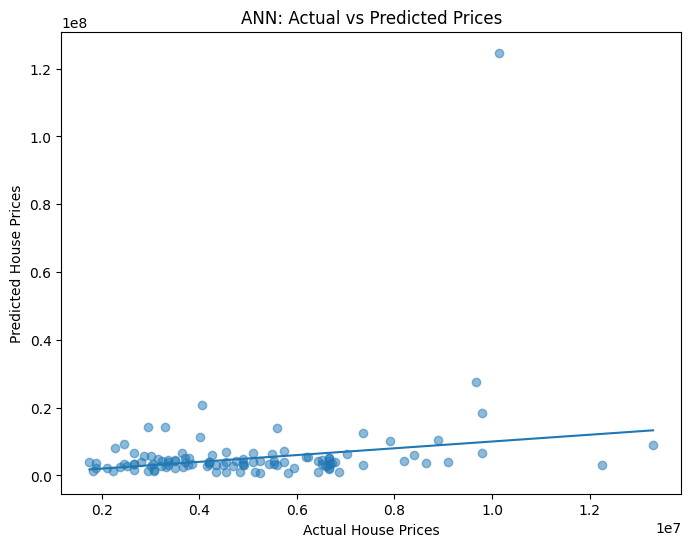

In [124]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(y_test_real, y_pred_real, alpha=0.5)
plt.plot([y_test_real.min(), y_test_real.max()],
         [y_test_real.min(), y_test_real.max()])
plt.xlabel("Actual House Prices")
plt.ylabel("Predicted House Prices")
plt.title("ANN: Actual vs Predicted Prices")
plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


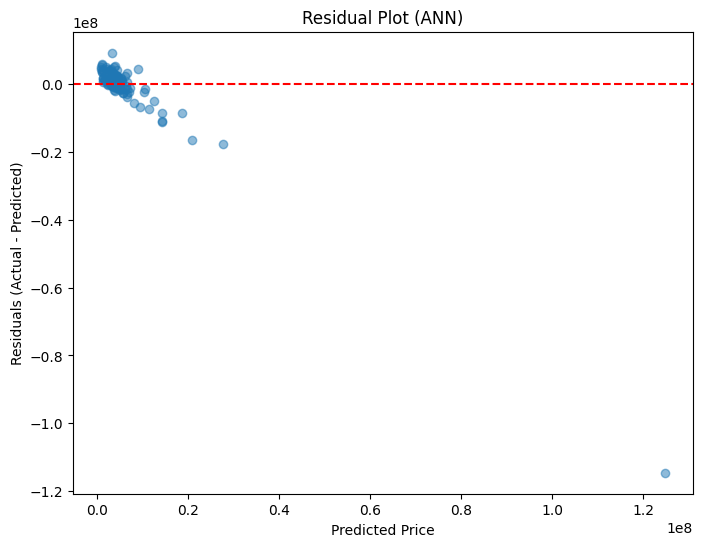

In [125]:
y_pred_ann = model.predict(X_test)

# inverse log
y_test_real = np.expm1(y_test.values)   # force numpy 1D
y_pred_real = np.expm1(y_pred_ann).ravel()  # 🔥 THIS LINE FIXES IT
residuals = y_test_real - y_pred_real
plt.figure(figsize=(8,6))
plt.scatter(y_pred_real, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')

plt.xlabel("Predicted Price")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot (ANN)")
plt.show()


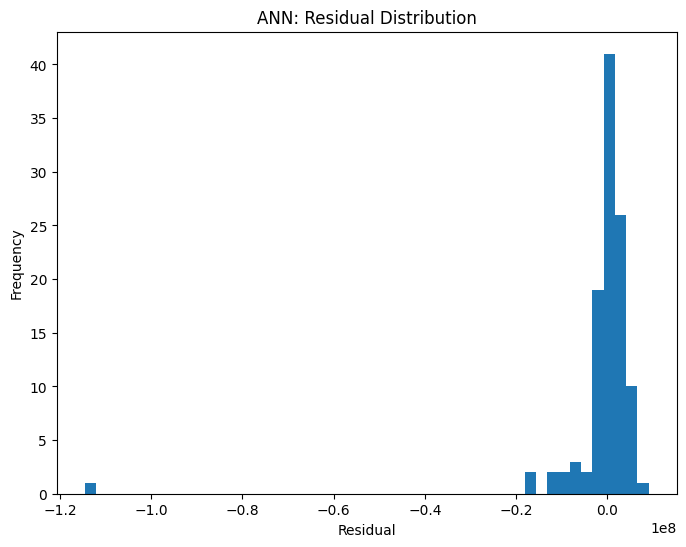

In [126]:
plt.figure(figsize=(8,6))
plt.hist(residuals, bins=50)
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.title("ANN: Residual Distribution")
plt.show()


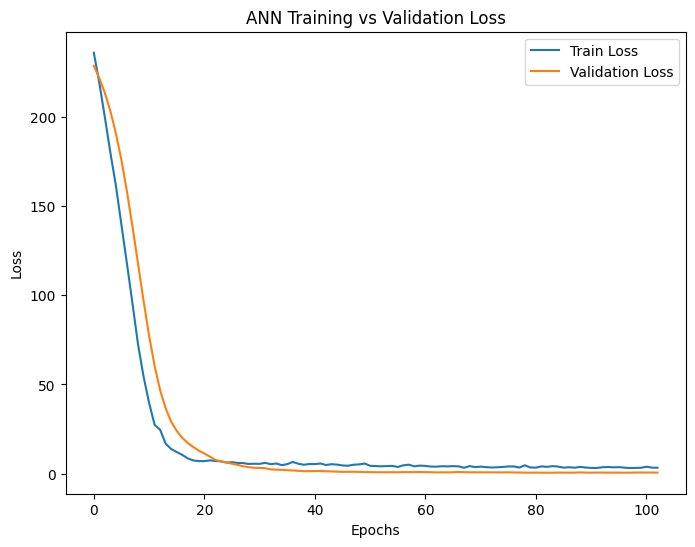

In [127]:
plt.figure(figsize=(8,6))

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("ANN Training vs Validation Loss")
plt.legend()
plt.show()


## XGBoost Model

In [140]:
from xgboost import XGBRegressor
xgb = XGBRegressor(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42
)

In [142]:
xgb.fit(
    X_train,
    y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=800,
             n_jobs=None, num_parallel_tree=None, ...)

XGBoost RMSE (real price): 1435748.01
XGBoost R²: 0.5922


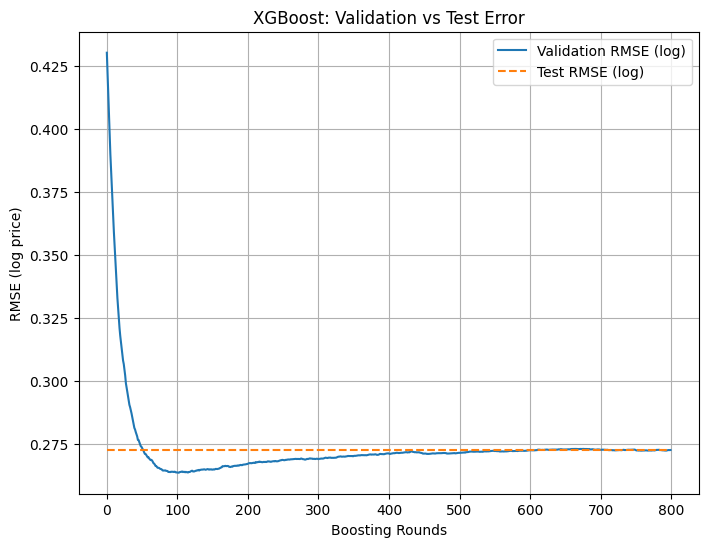

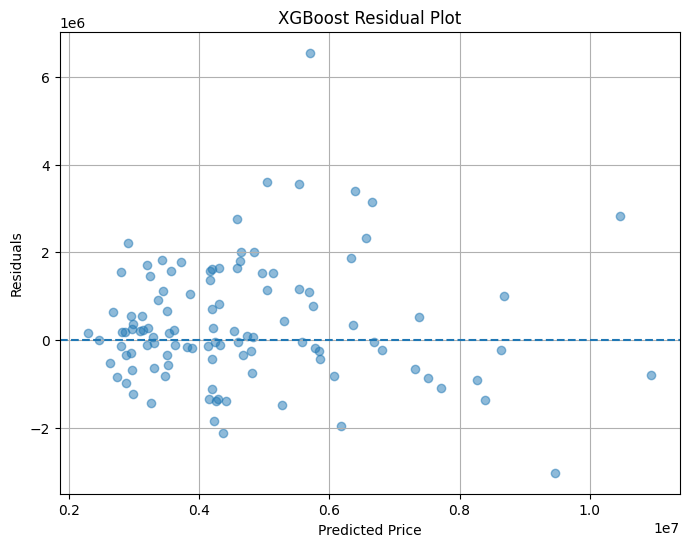

In [145]:
X_train, X_test, y_train_log, y_test_log = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


xgb = XGBRegressor(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    random_state=42
)


xgb.fit(
    X_train,
    y_train_log,
    eval_set=[(X_test, y_test_log)],
    verbose=False
)

y_pred_log = xgb.predict(X_test)


y_test_real = np.expm1(y_test_log)
y_pred_real = np.expm1(y_pred_log)


rmse = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
r2 = r2_score(y_test_real, y_pred_real)

print(f"XGBoost RMSE (real price): {rmse:.2f}")
print(f"XGBoost R²: {r2:.4f}")

Validation vs Test RMSE (LOG SCALE - CORRECT)

results = xgb.evals_result()
val_rmse_log = results['validation_0']['rmse']

test_rmse_log = np.sqrt(mean_squared_error(y_test_log, y_pred_log))
test_rmse_line = [test_rmse_log] * len(val_rmse_log)

plt.figure(figsize=(8,6))
plt.plot(val_rmse_log, label='Validation RMSE (log)')
plt.plot(test_rmse_line, '--', label='Test RMSE (log)')
plt.xlabel("Boosting Rounds")
plt.ylabel("RMSE (log price)")
plt.title("XGBoost: Validation vs Test Error")
plt.legend()
plt.grid(True)
plt.show()

#  Residual plot (REAL SCALE)

residuals = y_test_real - y_pred_real

plt.figure(figsize=(8,6))
plt.scatter(y_pred_real, residuals, alpha=0.5)
plt.axhline(0, linestyle='--')
plt.xlabel("Predicted Price")
plt.ylabel("Residuals")
plt.title("XGBoost Residual Plot")
plt.grid(True)
plt.show()